In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from torch.utils.data import Dataset, DataLoader
import time
import sys
import pandas as pd
import tensorflow as tf

https://www.researchgate.net/publication/347462953_Interpretable_and_effective_hashing_via_Bernoulli_variational_auto-encoders

In [2]:

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda:0


In [3]:
train_dataset2=np.genfromtxt('../input/mnist-in-csv/mnist_train.csv',delimiter=',')
train_dataset2=train_dataset2[1:1000,1:]
train_dataset2=np.where(train_dataset2>0.5,1,train_dataset2)
train_dataset2=np.where(train_dataset2<0.5,0,train_dataset2)
train_dataset2=torch.from_numpy(train_dataset2)



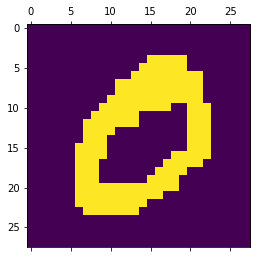

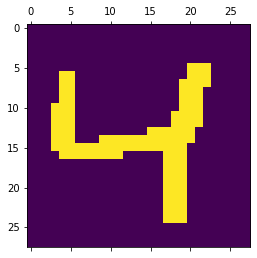

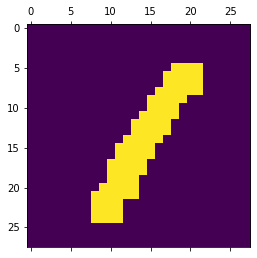

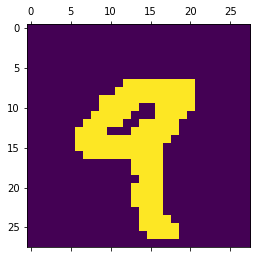

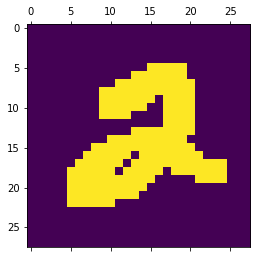

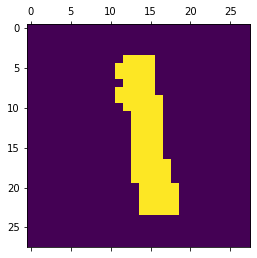

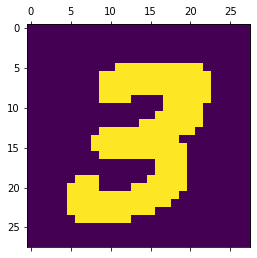

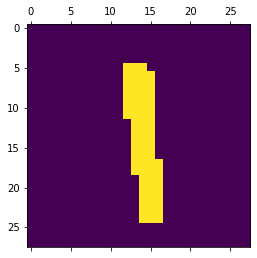

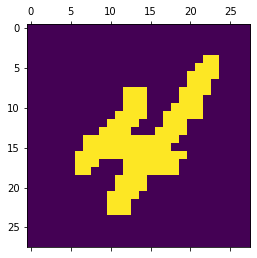

In [437]:
for i in train_dataset2[1:10]:
    plt.matshow(np.reshape(i.cpu().detach().numpy(),(28,28)))

In [4]:
##FOR IMPLEMENTING STRAIGHT THROUGH BVAE

class binarization(torch.autograd.Function):
    
    @staticmethod
    def forward(self,input):
        a=input.clone()
        a[a>0.5]=torch.tensor([1-(1e-5)])
        a[a<0.5]=torch.tensor([0+1e-5])
        return a

        
    @staticmethod
    def backward(self,grad_output):
        grad_input = grad_output.clone()
        return grad_input
        
        
        

In [5]:
class bVAE(nn.Module):
  def __init__(self,latent_dim):
    super(bVAE, self).__init__()
    
    self.encoder=nn.Sequential(
        nn.Linear(input_size,512),
        nn.LeakyReLU(0.1),

        nn.Linear(512,256),
        nn.LeakyReLU(0.1),

        nn.Linear(256,latent_dim),
        nn.Sigmoid(),
    )

    self.decoder=nn.Sequential(
        nn.Linear(latent_dim,256),
        nn.LeakyReLU(0.1),

        nn.Linear(256,512),
        nn.LeakyReLU(0.1),

        nn.Linear(512,input_size),
        nn.Sigmoid()
    )

  def encode(self,x):
    a= self.encoder(x)
    a=torch.clamp(a,min=1e-5,max=1-1e-5)
    return a

  def gumbel_reparam(self,a,lambd): # takes in the input from the encoder
    lambd=lambd.to(DEVICE)
    a=torch.clamp(a,min=1e-5,max=1-1e-5).to(DEVICE)
    u=torch.clamp(torch.rand(a.size()),min=1e-5,max=1-1e-5).to(DEVICE)
    x=((torch.log(a/(1-a))+torch.log(u/(1-u)))/lambd).to(DEVICE)
    x=torch.sigmoid(x)
    x=torch.clamp(x,min=1e-5,max=1-1e-5)
    return x



  def decode(self,x):
    d=self.decoder(x)
    return d


  def forward(self,x):
    e=self.encode(x)
    g=self.gumbel_reparam(e,lambd)
    b=binarization.apply(g)
    d=self.decode(g)
    return d,b,g,e


In [6]:
#model=torch.load('../input/modeld/model')

Everytime you call load a pretrained model, want to continue training, make surre that the lambda vallue is where you left it at

In [7]:

input_size=784#3600
latent_dim=500
LEARNING_RATE=1e-4

num_epochs=2000

lambd=torch.Tensor([0.4])
lambd_min=torch.Tensor([0.4])
lambd_learning_rate=torch.Tensor([3e-5])


model=bVAE(latent_dim)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [8]:
#model.load_state_dict(torch.load('../input/hello1/bVAE_state_dict_batch6'))

<All keys matched successfully>

In [170]:
def compute_loss(model,x):
    x_hat,bi,gumbell,a=model(x)
    reconstruction_loss=torch.mean(torch.square(x-x_hat))
    #reconstruction_loss=F.mse_loss(x,x_hat)
    KL_loss=torch.mean(latent_dim*np.log(2) + torch.sum(a*torch.log(a)+(1-a)*torch.log(1-a)))
    total_loss=250*reconstruction_loss+KL_loss
    return total_loss,reconstruction_loss,KL_loss

def compute_loss2(model,x): ### WRONG!!!! CHECK THE AXIS OF KL_LOSS...should be 1
    x_hat,bi,gumbell,a=model(x)
    reconstruction_loss=torch.mean(torch.square(x-x_hat))
    #reconstruction_loss=torch.mean(F.mse_loss(x,x_hat))
    KL_loss=torch.mean(latent_dim*np.log(2) + torch.sum(a*torch.log(a)+(1-a)*torch.log(1-a),axis=0))
    total_loss=250*reconstruction_loss+KL_loss
    return total_loss,reconstruction_loss,KL_loss


def compute_loss_batch(model,x):
    x_hat,bi,gumbell,a=model(x)
    reconstruction_loss=torch.mean(torch.square(x-x_hat))
    #reconstruction_loss=torch.mean(F.mse_loss(x,x_hat))
    KL_loss=torch.mean(latent_dim*np.log(2) + torch.sum(a*torch.log(a)+(1-a)*torch.log(1-a),axis=1))
    total_loss=250*reconstruction_loss+KL_loss
    return total_loss,reconstruction_loss,KL_loss

In [156]:
x_hat,bi,gumbell,a=model(train_dataset2.float())

In [160]:
a.size()

torch.Size([999, 500])

In [166]:
torch.mean(torch.sum(a*torch.log(a)+(1-a)*torch.log(1-a),axis=1)+latent_dim*np.log(2) )

tensor(3.6586, device='cuda:0', grad_fn=<MeanBackward0>)

In [169]:
torch.mean((x_hat-train_dataset2.float()),axis=1).size()

torch.Size([999])

In [167]:
compute_loss_batch(model,train_dataset2.float())

(tensor(12.7055, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0362, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(3.6586, device='cuda:0', grad_fn=<MeanBackward0>))

In [107]:
t=[]
r=[]
k=[]
ll=[]

In [ ]:


model.train()

for i in range(100):
  for j in train_dataset2:
    start_time = time.time()
    optimizer.zero_grad()
    j=j.to(DEVICE)

    tl,rl,kl=compute_loss(model,j.float())

    t.append(tl)
    r.append(rl)
    k.append(kl)

    tl.backward()
    optimizer.step()
  print('Time for epoch {} is {} sec, Loss: {},{},{} '.format(i + 1, time.time()-start_time,tl,rl,kl))
  if (i%100):
    if lambd>lambd_min:
      lambd=lambd*np.exp(-lambd_learning_rate*i)
      ll.append(lambd)

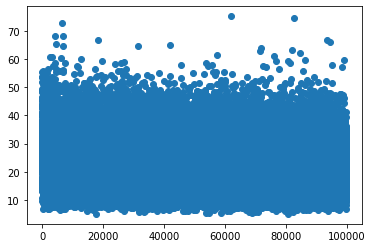

In [109]:
x=np.arange(len(t))
t=list(map(float, t))
plt.scatter(x,t)

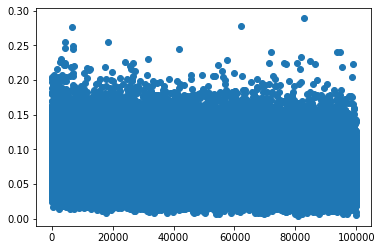

In [110]:
x=np.arange(len(r))
r=list(map(float, r))
plt.scatter(x,r)

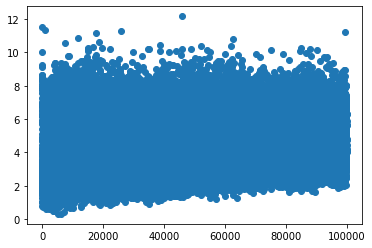

In [111]:
x=np.arange(len(k))
k=list(map(float,k))
plt.scatter(x,k)

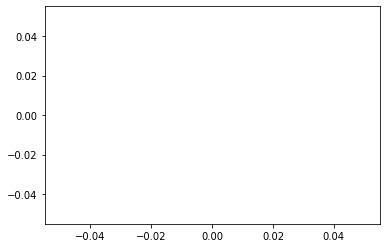

In [112]:
x=np.arange(len(ll))
ll=list(map(float, ll))
plt.scatter(x,ll)

In [393]:
t=[]
r=[]
k=[]
ll=[]

In [424]:
model.train()

for i in range(200000):
    start_time = time.time()
    optimizer.zero_grad()
    train_dataset2=train_dataset2.to(DEVICE)

    tl,rl,kl=compute_loss_batch(model,train_dataset2.float())

    t.append(tl)
    r.append(rl)
    k.append(kl)

    tl.backward()
    optimizer.step()
    if (i%1000==0):
        print('Time for epoch {} is {} sec, Loss: {},{},{} '.format(i + 1, time.time()-start_time,tl,rl,kl))
    if (i%100):
        if lambd>lambd_min:
            lambd=lambd*np.exp(-lambd_learning_rate*i)
            
    ll.append(lambd)

Time for epoch 1 is 0.013923168182373047 sec, Loss: 7.508150577545166,0.002260209759697318,6.943098068237305 
Time for epoch 1001 is 0.007807493209838867 sec, Loss: 7.546779632568359,0.002409297274425626,6.944455146789551 
Time for epoch 2001 is 0.008515119552612305 sec, Loss: 7.583377838134766,0.0025581903755664825,6.9438300132751465 
Time for epoch 3001 is 0.007797718048095703 sec, Loss: 7.533530235290527,0.0023664843756705523,6.941909313201904 
Time for epoch 4001 is 0.007894039154052734 sec, Loss: 7.526991844177246,0.002340023871511221,6.941986083984375 
Time for epoch 5001 is 0.009284496307373047 sec, Loss: 7.496478080749512,0.0022156143095344305,6.942574501037598 
Time for epoch 6001 is 0.0077838897705078125 sec, Loss: 7.460118293762207,0.002075271448120475,6.941300392150879 
Time for epoch 7001 is 0.007994651794433594 sec, Loss: 7.46727991104126,0.002104648621752858,6.941117763519287 
Time for epoch 8001 is 0.007764339447021484 sec, Loss: 7.4807891845703125,0.0021587915252894163

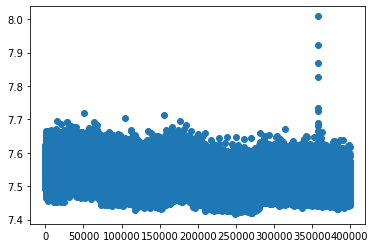

In [425]:
x=np.arange(len(t))
t=list(map(float, t))
plt.scatter(x,t)

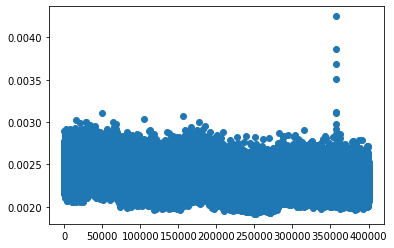

In [426]:
x=np.arange(len(r))
r=list(map(float, r))
plt.scatter(x,r)

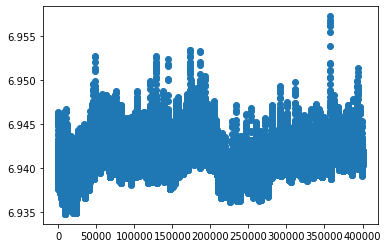

In [427]:
x=np.arange(len(k))
k=list(map(float, k))
plt.scatter(x,k)

In [428]:
model.eval()

bVAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=256, out_features=500, bias=True)
    (5): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=500, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

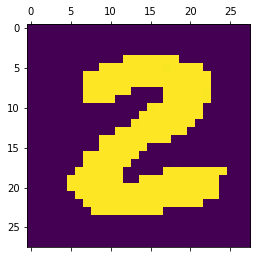

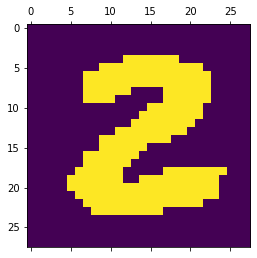

In [455]:
x=train_dataset2[np.random.randint(0,100)]
y=model(x.float().to(DEVICE))[0]
y=y.cpu().detach().numpy()
y=np.reshape(y,(28,28))
plt.matshow(y)

x1=x
x1=x1.cpu().detach().numpy()
plt.matshow(x1.reshape((28,28)))

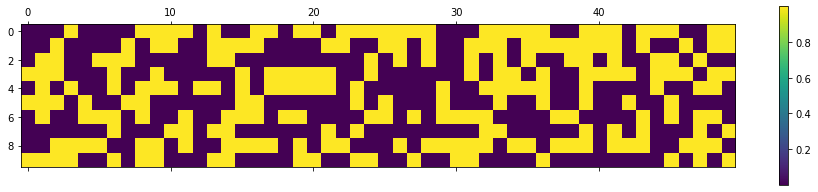

In [430]:
b=model(x.float().to(DEVICE))[1]
b=b.cpu().detach().numpy()
b=np.reshape(b,(10,50))
plt.matshow(b)
plt.colorbar()

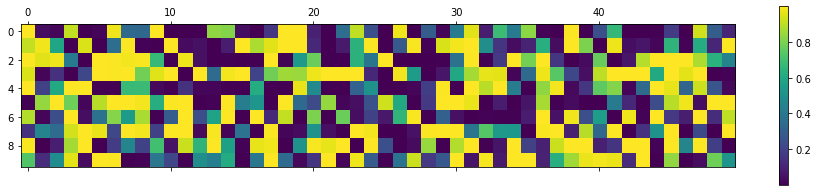

In [431]:
g=model(x.float().to(DEVICE))[2]
g=g.cpu().detach().numpy()
g=np.reshape(g,(10,50))
plt.matshow(g)
plt.colorbar()

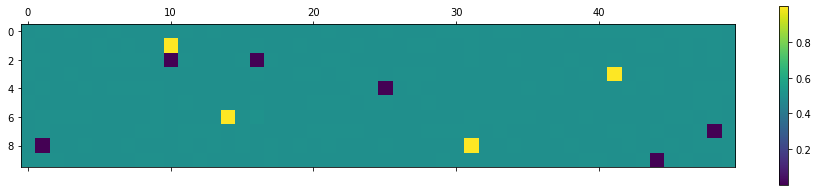

In [432]:
a=model(x.float().to(DEVICE))[3]
a=a.cpu().detach().numpy()
a=np.reshape(a,(10,50))
plt.matshow(a)
plt.colorbar()

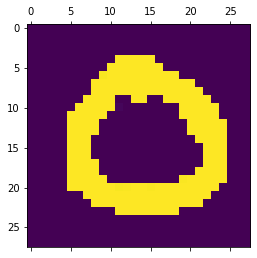

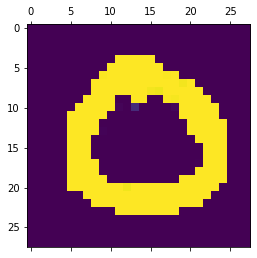

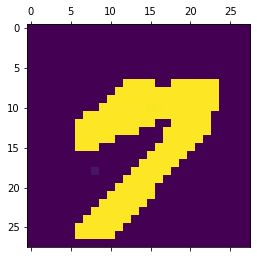

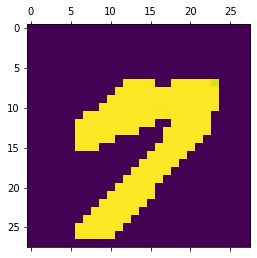

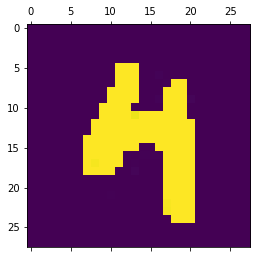

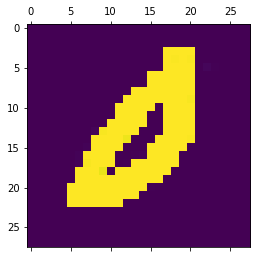

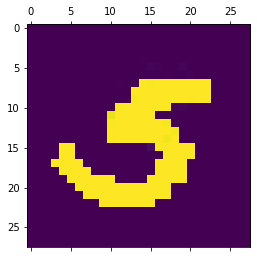

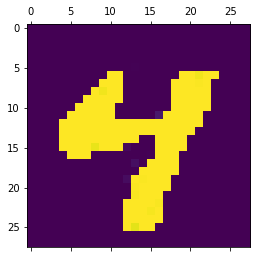

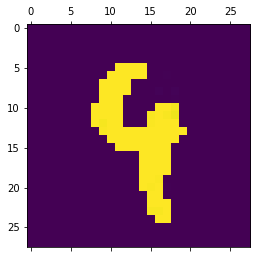

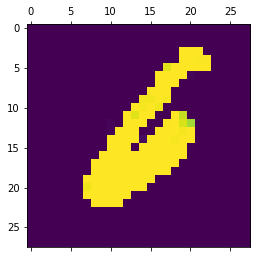

In [433]:
for i in range(10):
    a_check=torch.rand((latent_dim,))
    decoder_input=torch.bernoulli(a_check) .to(DEVICE)
    output=model.decode(decoder_input)
    
    output=output.cpu().detach().numpy()
    output=np.reshape(output,(28,28))
    plt.matshow(output)

In [434]:
model(x.float().to(DEVICE))

(tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 8.4528e-28, 3.9068e-26, 5.0230e-34, 6.0884e-29, 3.3470e-21,
         0.0000e+00, 0.0000e

In [435]:
torch.save(model.state_dict(),'bVAE_state_dict_batch_final_v3')

In [436]:
torch.save(model, 'model_batch_final_v3')